In [1]:
# 셀 1: 주요 라이브러리 임포트 (PyTorch Ver.)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 데이터 전처리 도구
from sklearn.preprocessing import MinMaxScaler

print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.7.0+cu118


In [2]:
# 셀 2: 데이터 로드 및 기본 정보 확인
# Colab 환경에 Location1.csv 파일을 업로드한 후 실행하세요.
try:
    df_train = pd.read_csv('Location1.csv')
    print("훈련 데이터셋 로드 성공!")
    print("데이터 샘플 (처음 5줄):")
    print(df_train.head())
    print("\n데이터 정보:")
    df_train.info()
except FileNotFoundError:
    print("Error: 'Location1.csv' 파일을 찾을 수 없습니다.")
    print("Colab의 파일 세션에 해당 파일을 업로드해주세요.")

훈련 데이터셋 로드 성공!
데이터 샘플 (처음 5줄):
                  Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0  2017-01-02 00:00:00            28.5                   85         24.5   
1  2017-01-02 01:00:00            28.4                   86         24.7   
2  2017-01-02 02:00:00            26.8                   91         24.5   
3  2017-01-02 03:00:00            27.4                   88         24.3   
4  2017-01-02 04:00:00            27.3                   88         24.1   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           1.44            1.26                146                 162   
1           2.06            3.99                151                 158   
2           1.30            2.78                148                 150   
3           1.30            2.69                 58                 105   
4           2.47            4.43                 58                  84   

   windgusts_10m   Power  
0            1.4  0.1635  
1      

In [3]:
# 셀 3: 특성 선택 및 데이터 정규화
# 'Time' 컬럼을 datetime 형식으로 변환하고 인덱스로 설정합니다.
df_train['Time'] = pd.to_datetime(df_train['Time'])
df_train.set_index('Time', inplace=True)

# 모델에 사용할 특성과 목표 변수를 정의합니다.
FEATURES = ['windspeed_10m', 'windspeed_100m', 'windgusts_10m', 'dewpoint_2m']
TARGET = 'Power'

# 데이터프레임에서 특성과 타겟을 분리
data_features = df_train[FEATURES]
data_target = df_train[[TARGET]] # 데이터프레임 형태 유지를 위해 이중 대괄호 사용

# 특성용 스케일러와 타겟용 스케일러를 각각 생성하고 피팅합니다.
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(data_features)

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(data_target)

print("특성 데이터 Shape:", scaled_features.shape)
print("타겟 데이터 Shape:", scaled_target.shape)

특성 데이터 Shape: (43800, 4)
타겟 데이터 Shape: (43800, 1)


In [4]:
# 셀 4: 시계열 데이터를 시퀀스로 변환하는 함수 정의
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        # features: i 부터 i+sequence_length-1 까지의 데이터
        X.append(features[i:i + sequence_length])
        # target: i+sequence_length 시점의 데이터
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# 시퀀스 길이 설정 (예: 지난 24시간의 데이터를 기반으로 예측)
SEQUENCE_LENGTH = 24

# 함수를 사용하여 시퀀스 데이터 생성
X, y = create_sequences(scaled_features, scaled_target, SEQUENCE_LENGTH)

print("생성된 시퀀스 데이터 Shape:")
print("X shape:", X.shape) # (샘플 수, 시퀀스 길이, 특성 수)
print("y shape:", y.shape) # (샘플 수, 1)

생성된 시퀀스 데이터 Shape:
X shape: (43776, 24, 4)
y shape: (43776, 1)


In [26]:
# 2. 데이터를 훈련 세트, 검증 세트, 테스트 세트로 분할
# 데이터의 80%를 훈련용, 10%를 검증용, 10%를 테스트용으로 사용
train_size = int(len(X_tensor) * 0.8)
val_size = int(len(X_tensor) * 0.9)  # 80% + 10% = 90%

X_train, X_val, X_test = X_tensor[:train_size], X_tensor[train_size:val_size], X_tensor[val_size:]
y_train, y_val, y_test = y_tensor[:train_size], y_tensor[train_size:val_size], y_tensor[val_size:]

print(f"훈련 데이터 Shape:  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"검증 데이터 Shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"테스트 데이터 Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# 3. TensorDataset과 DataLoader 생성
BATCH_SIZE = 32 # 한 번에 처리할 데이터 묶음의 크기

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoader가 생성되었습니다.")
print(f"총 {len(train_loader)}개의 훈련 배치, {len(val_loader)}개의 검증 배치, {len(test_loader)}개의 테스트 배치가 준비되었습니다.")

훈련 데이터 Shape:  X_train: torch.Size([35020, 24, 4]), y_train: torch.Size([35020, 1])
검증 데이터 Shape: X_val: torch.Size([4378, 24, 4]), y_val: torch.Size([4378, 1])
테스트 데이터 Shape: X_test: torch.Size([4378, 24, 4]), y_test: torch.Size([4378, 1])

DataLoader가 생성되었습니다.
총 1095개의 훈련 배치, 137개의 검증 배치, 137개의 테스트 배치가 준비되었습니다.


In [9]:
# 셀 6: 개선된 LSTM 모델 클래스 정의 및 하이퍼파라미터 설정

# GPU 사용 가능 여부 확인 및 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델의 하이퍼파라미터 정의
INPUT_SIZE = len(FEATURES)  # 입력 특성의 수 (피처 엔지니어링으로 늘어날 수 있음)
HIDDEN_SIZE = 256           # LSTM 계층의 뉴런(유닛) 수
NUM_LAYERS = 4              # 쌓아 올릴 LSTM 계층의 수
OUTPUT_SIZE = 1             # 예측할 값의 수 (Power 1개)
DROPOUT_RATE = 0.35         # 드롭아웃 비율

# 개선된 LSTM 모델 클래스 정의
class PowerLSTM_v2(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(PowerLSTM_v2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. 양방향(Bidirectional) LSTM 적용
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True  # 양방향 설정
        )

        # 2. 더 복잡한 출력층(Head) 구성
        # 양방향이므로 hidden_size * 2가 입력 차원이 됨
        self.fc_head = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size), # 입력 크기를 2배로
            nn.ReLU(),                               # 활성화 함수
            nn.Dropout(dropout_rate),                # 드롭아웃 추가
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # 양방향이므로 은닉/셀 상태의 첫 번째 차원도 2배가 되어야 함
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 타임스텝의 출력만 사용
        out = self.fc_head(out[:, -1, :])
        return out


Using device: cuda


모델 훈련을 시작합니다...
Epoch [1/100], Train Loss: 0.047329, Val Loss: 0.037735
Validation loss improved. Saving model to best_model.pth
Epoch [2/100], Train Loss: 0.033380, Val Loss: 0.036507
Validation loss improved. Saving model to best_model.pth
Epoch [3/100], Train Loss: 0.031905, Val Loss: 0.034926
Validation loss improved. Saving model to best_model.pth
Epoch [4/100], Train Loss: 0.031045, Val Loss: 0.035812
Validation loss did not improve. Patience counter: 1/5
Epoch [5/100], Train Loss: 0.030831, Val Loss: 0.033313
Validation loss improved. Saving model to best_model.pth
Epoch [6/100], Train Loss: 0.030647, Val Loss: 0.030588
Validation loss improved. Saving model to best_model.pth
Epoch [7/100], Train Loss: 0.030365, Val Loss: 0.029251
Validation loss improved. Saving model to best_model.pth
Epoch [8/100], Train Loss: 0.030054, Val Loss: 0.028006
Validation loss improved. Saving model to best_model.pth
Epoch [9/100], Train Loss: 0.029847, Val Loss: 0.027696
Validation loss improved. 

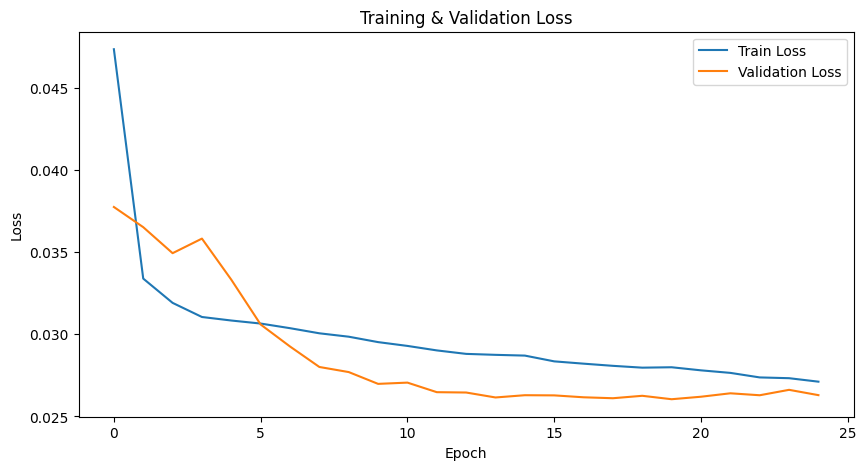

In [11]:
import numpy as np
import torch

# --- 조기 종료 파라미터 ---
patience = 5  # 검증 손실이 5 epoch 동안 개선되지 않으면 훈련을 조기 종료
patience_counter = 0
best_val_loss = float('inf') # 가장 좋았던 검증 손실을 저장하기 위한 변수 (무한대로 초기화)
model_path = 'best_model.pth' # 가장 좋은 모델을 저장할 경로

# 모델 인스턴스 생성 및 디바이스로 이동
model = PowerLSTM_v2(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 훈련 시작
NUM_EPOCHS = 100 # 최대 Epoch 횟수를 넉넉하게 설정
print("모델 훈련을 시작합니다...")

history = {'train_loss': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    # --- 훈련 모드 ---
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 가중치 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # --- 검증 모드 ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad(): # 그라디언트 계산 비활성화
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # --- 조기 종료 로직 ---
    # 현재 검증 손실이 이전 최저 손실보다 낮으면 모델을 저장하고 counter 초기화
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_path) # 가장 좋은 모델 상태 저장
        patience_counter = 0
        print(f'Validation loss improved. Saving model to {model_path}')
    # 검증 손실이 개선되지 않으면 counter 증가
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience counter: {patience_counter}/{patience}')

    # 만약 counter가 설정한 patience에 도달하면 훈련 중단
    if patience_counter >= patience:
        print("\n조기 종료: 검증 손실이 더 이상 개선되지 않아 훈련을 중단합니다.")
        break

# --- 훈련 종료 후 ---
# 훈련이 조기 종료되었든, 모든 Epoch를 완료했든 가장 성능이 좋았던 모델 불러오기
print(f"\n훈련 완료! 가장 성능이 좋았던 모델({model_path})을 불러옵니다.")
model.load_state_dict(torch.load(model_path))


# 훈련 과정의 손실(Loss) 변화 시각화
plt.figure(figsize=(10, 5))
# history에 기록된 만큼만 그래프를 그립니다.
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

검증 데이터에 대한 최종 RMSE: 0.1600


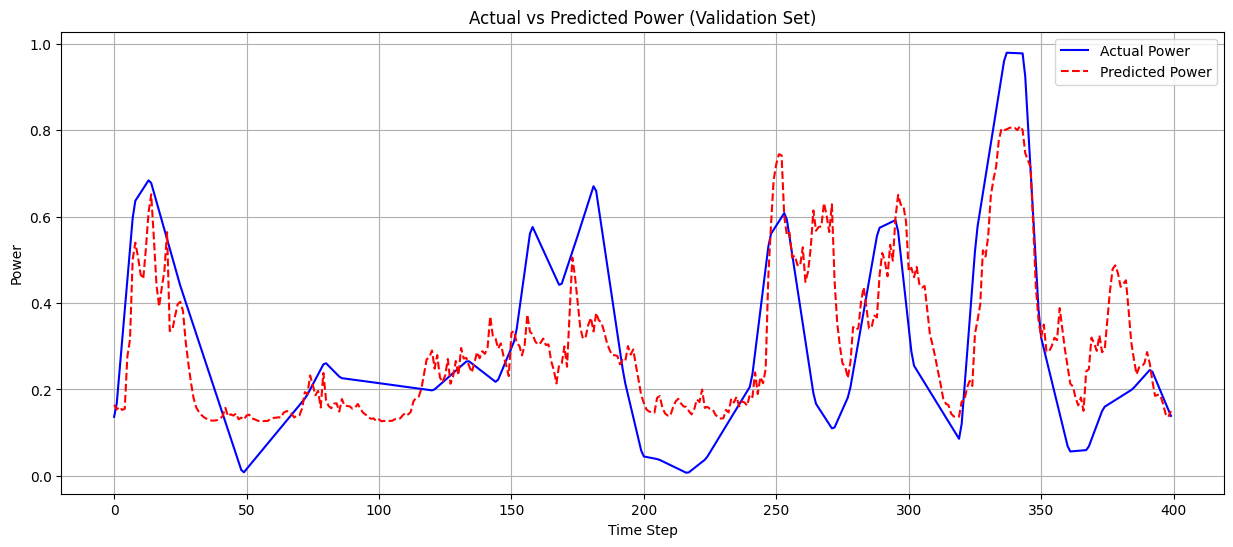

In [12]:
# 셀 8: 검증 데이터에 대한 예측 및 성능 평가

# 1. 모델을 평가 모드로 설정
model.eval()

# 2. 검증 데이터로 예측 수행
with torch.no_grad():
    y_pred_tensor = model(X_val.to(device))

# 3. 예측 결과를 CPU로 이동시키고 Numpy 배열로 변환
y_pred = y_pred_tensor.cpu().numpy()

# 실제값도 Numpy 배열로 변환
y_true = y_val.numpy()


# 4. 정규화된 예측값과 실제값을 원래 스케일로 되돌림
y_pred_inv = scaler_target.inverse_transform(y_pred)
y_true_inv = scaler_target.inverse_transform(y_true)

# 5. 성능 지표(RMSE) 계산
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
print(f'검증 데이터에 대한 최종 RMSE: {rmse:.4f}')


# 6. 결과 시각화 (검증 데이터 중 첫 400개 타임스텝)
plt.figure(figsize=(15, 6))
plt.plot(y_true_inv[:400], label='Actual Power', color='blue')
plt.plot(y_pred_inv[:400], label='Predicted Power', color='red', linestyle='--')
plt.title('Actual vs Predicted Power (Validation Set)')
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Attention 메커니즘을 위한 별도의 모듈
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        # 양방향 LSTM을 사용하므로 hidden_size * 2
        self.attn = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.v = nn.Parameter(torch.rand(hidden_size * 2))

    def forward(self, hidden_states):
        # hidden_states: (batch_size, seq_len, hidden_size * 2)
        
        # 1. 에너지 점수 계산
        energy = torch.tanh(self.attn(hidden_states))
        # energy: (batch_size, seq_len, hidden_size * 2)

        # 2. 에너지와 가중치 벡터(v)의 내적(dot product)으로 최종 점수 계산
        # (batch_size, seq_len, hidden_size*2) * (hidden_size*2) -> (batch_size, seq_len)
        attn_scores = torch.einsum('bij,j->bi', energy, self.v)

        # 3. Softmax를 통해 Attention 가중치 계산
        attention_weights = F.softmax(attn_scores, dim=1)
        # attention_weights: (batch_size, seq_len)

        # 4. 컨텍스트 벡터 계산 (가중 합)
        # (batch_size, 1, seq_len) * (batch_size, seq_len, hidden_size*2) -> (batch_size, 1, hidden_size*2)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), hidden_states)
        
        return context_vector, attention_weights

In [14]:
import torch.nn.functional as F

# Attention을 적용한 최종 LSTM 모델 클래스
class PowerLSTM_Attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(PowerLSTM_Attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True  # Attention은 양방향 LSTM과 시너지가 좋음
        )

        # 위에서 정의한 Attention 모듈을 인스턴스화
        self.attention = Attention(hidden_size)

        # 최종 출력층: LSTM의 마지막 출력과 Attention 컨텍스트 벡터를 함께 사용
        # 입력 크기: (hidden_size * 2) + (hidden_size * 2) = hidden_size * 4
        self.fc = nn.Linear(hidden_size * 4, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # LSTM 순전파
        # lstm_out: 모든 타임 스텝의 은닉 상태 (batch_size, seq_len, hidden_size * 2)
        lstm_out, _ = self.lstm(x, (h0, c0))

        # Attention 메커니즘 적용
        # context_vector: (batch_size, 1, hidden_size * 2)
        # attention_weights: (batch_size, seq_len)
        context_vector, attention_weights = self.attention(lstm_out)
        
        # 컨텍스트 벡터 차원 변경: (batch_size, hidden_size * 2)
        context_vector = context_vector.squeeze(1)

        # LSTM의 마지막 타임 스텝 출력
        # lstm_out[:, -1, :]는 순방향 마지막 은닉 상태와 역방향 첫 은닉 상태가 합쳐진 것
        last_hidden_state = lstm_out[:, -1, :]

        # 마지막 은닉 상태와 컨텍스트 벡터를 결합(concatenate)
        combined_output = torch.cat((last_hidden_state, context_vector), dim=1)

        # 최종 예측
        output = self.fc(combined_output)
        
        # 예측값과 함께 Attention 가중치도 반환 (시각화를 위해)
        return output, attention_weights

모델 훈련을 시작합니다...
Epoch [1/100], Train Loss: 0.044970, Val Loss: 0.033063
Validation loss improved. Saving model to best_model.pth
Epoch [2/100], Train Loss: 0.033037, Val Loss: 0.030679
Validation loss improved. Saving model to best_model.pth
Epoch [3/100], Train Loss: 0.030430, Val Loss: 0.028222
Validation loss improved. Saving model to best_model.pth
Epoch [4/100], Train Loss: 0.029581, Val Loss: 0.029833
Validation loss did not improve. Patience counter: 1/5
Epoch [5/100], Train Loss: 0.029109, Val Loss: 0.028595
Validation loss did not improve. Patience counter: 2/5
Epoch [6/100], Train Loss: 0.028666, Val Loss: 0.027253
Validation loss improved. Saving model to best_model.pth
Epoch [7/100], Train Loss: 0.028327, Val Loss: 0.026570
Validation loss improved. Saving model to best_model.pth
Epoch [8/100], Train Loss: 0.028115, Val Loss: 0.026234
Validation loss improved. Saving model to best_model.pth
Epoch [9/100], Train Loss: 0.027858, Val Loss: 0.026005
Validation loss improved. Sa

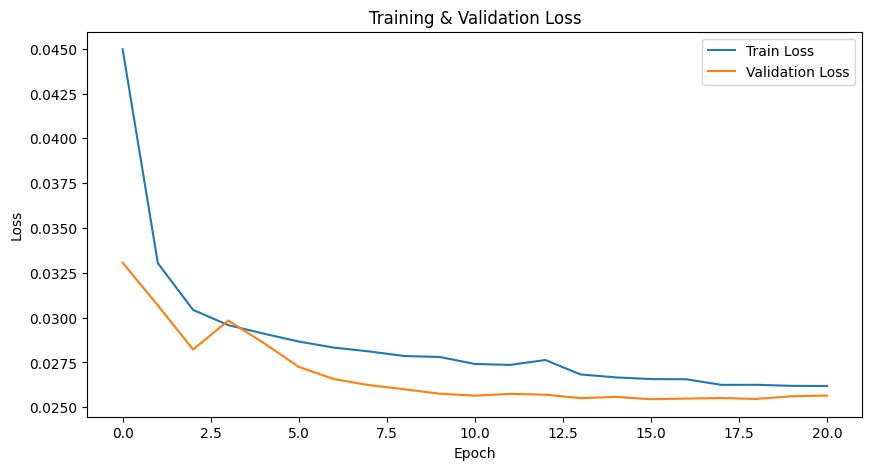

In [ ]:
# 테스트 데이터로 예측 및 시각화 예시
model.eval()
with torch.no_grad():
    # 예시 데이터 (하나의 배치)
    sample_inputs, sample_labels = next(iter(test_loader))
    sample_inputs = sample_inputs.to(device)
    
    # 예측 및 Attention 가중치 얻기
    predictions, weights = model(sample_inputs)
    
    # 첫 번째 데이터의 가중치를 시각화
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(weights[0])), weights[0].cpu().numpy())
    plt.title('Attention Weights for a Single Prediction')
    plt.xlabel('Time Step in Input Sequence')
    plt.ylabel('Attention Weight')
    plt.show()

In [33]:
# (X_test, y_test는 이미 텐서이므로 변환 불필요)

# 1. 텐서 데이터셋 생성
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# 2. 데이터로더 생성
BATCH_SIZE = 64  # 훈련 시 사용했던 배치 사이즈와 동일하게 설정
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("test_loader가 성공적으로 생성되었습니다.")

test_loader가 성공적으로 생성되었습니다.


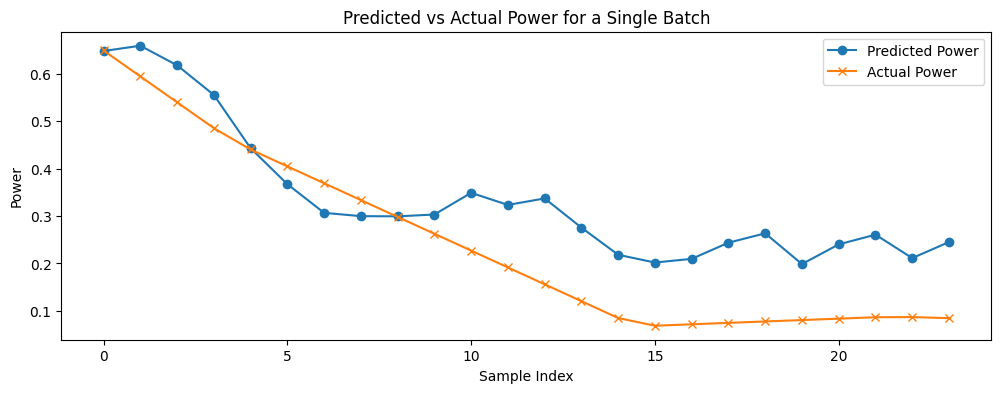

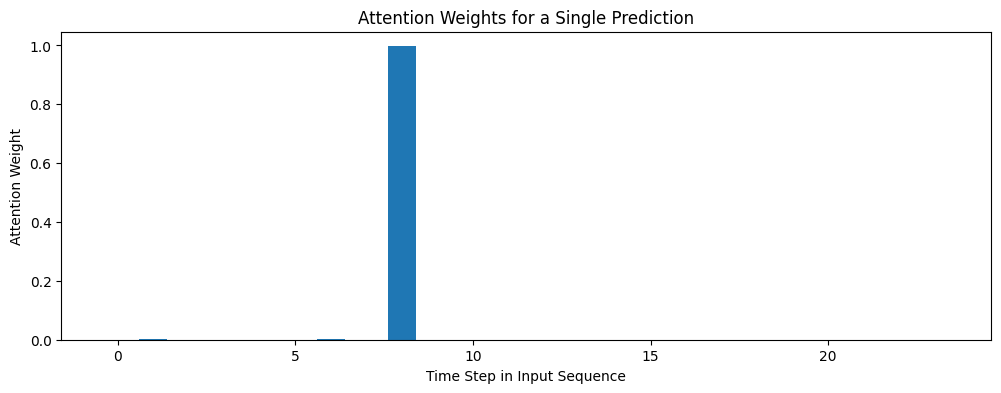

In [40]:
model.eval()
with torch.no_grad():
    # 예시 데이터 (하나의 배치)
    sample_inputs, sample_labels = next(iter(test_loader))
    sample_inputs = sample_inputs.to(device)
    sample_labels = sample_labels.to(device)
    
    # 예측 및 Attention 가중치 얻기
    predictions, weights = model(sample_inputs)  # Unpack the tuple
    
    # 역정규화 (스케일링된 값을 원래 값으로 변환)
    predictions = scaler_target.inverse_transform(predictions.cpu().numpy())
    sample_labels = scaler_target.inverse_transform(sample_labels.cpu().numpy())
    
    # 첫 번째 데이터의 예측값과 실제값 시각화
    plt.figure(figsize=(12, 4))
    plt.plot(predictions[:24], label='Predicted Power', marker='o')
    plt.plot(sample_labels[:24], label='Actual Power', marker='x')
    plt.title('Predicted vs Actual Power for a Single Batch')
    plt.xlabel('Sample Index')
    plt.ylabel('Power')
    plt.legend()
    plt.show()
    
    # Optionally, visualize attention weights
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(weights[0])), weights[0].cpu().numpy())
    plt.title('Attention Weights for a Single Prediction')
    plt.xlabel('Time Step in Input Sequence')
    plt.ylabel('Attention Weight')
    plt.show()